In [4]:
import tweetnlp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

/Users/novarac23/.pyenv/versions/3.10.6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12, 8)})

In [138]:
def _get_sentiment(tweet):
    sentiment = model.predict(tweet)
    return sentiment['label']  

In [152]:
def _simplify_sentiment(sentiment):
    if sentiment == 'joy':
        return 'joy & optimism'
    elif sentiment == 'optimism':
        return 'joy & optimism'
    elif sentiment == 'anger':
        return 'anger & sadness'
    else:
        return 'anger & sadness'

In [6]:
tweets = pd.read_csv("data (scraped files)/ev_tweets_raw.csv")
model = tweetnlp.Classifier("cardiffnlp/twitter-roberta-base-dec2021-emotion", max_length=128) # load model. More info here: https://huggingface.co/cardiffnlp/twitter-roberta-base-dec2021-emotion?text=I+really+don%27t+like+electric+vehicles

In [7]:
# basic data preprocessing
tweets.drop_duplicates(subset=['text'], inplace=True) # drop duplicates

# removing stopwords
stop = stopwords.words('english')
tweets['tweet_formatted'] = tweets['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# remove numerical values
dig_regex = '\\b[0-9]+\\b'
tweets['tweet_formatted'] = tweets['tweet_formatted'].str.replace(dig_regex,'')

# remove punctuation
punc_regex = '[^\w\s]'
tweets['tweet_formatted'] = tweets['tweet_formatted'].str.replace(punc_regex, '')

# change to lowercase
tweets['tweet_formatted'] = tweets['tweet_formatted'].apply(lambda x: " ".join(x.lower() for x in x.split()))

/var/folders/t2/srrvkmmn5650mcqhq9k36xxh0000gn/T/ipykernel_60396/3086418035.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['tweet_formatted'] = tweets['tweet_formatted'].str.replace(dig_regex,'')
/var/folders/t2/srrvkmmn5650mcqhq9k36xxh0000gn/T/ipykernel_60396/3086418035.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['tweet_formatted'] = tweets['tweet_formatted'].str.replace(punc_regex, '')


In [8]:
tweets.head()

,created_at,text,keyword,tweet_formatted
0,2023-04-23 16:52:00+00:00,New Post: I Love How Tesla Wreaks Havoc among ...,love AND tesla,new post i love how tesla wreaks havoc among a...
1,2023-04-23 16:51:26+00:00,@garyblack00 @elonmusk That's not a fair quest...,love AND tesla,garyblack00 elonmusk thats fair question i lov...
2,2023-04-23 16:51:25+00:00,YOUR DEFINITIVE SUNDAY READ.\n\nVery BALANCED ...,love AND tesla,your definitive sunday read very balanced amp ...
3,2023-04-23 16:49:53+00:00,@EvasTeslaSPlaid @Tesla Classy and sporty. I l...,love AND tesla,evasteslasplaid tesla classy sporty i love
4,2023-04-23 16:46:28+00:00,@elonmusk @MarioNawfal Love you Elon waiting f...,love AND tesla,elonmusk marionawfal love elon waiting tesla p...


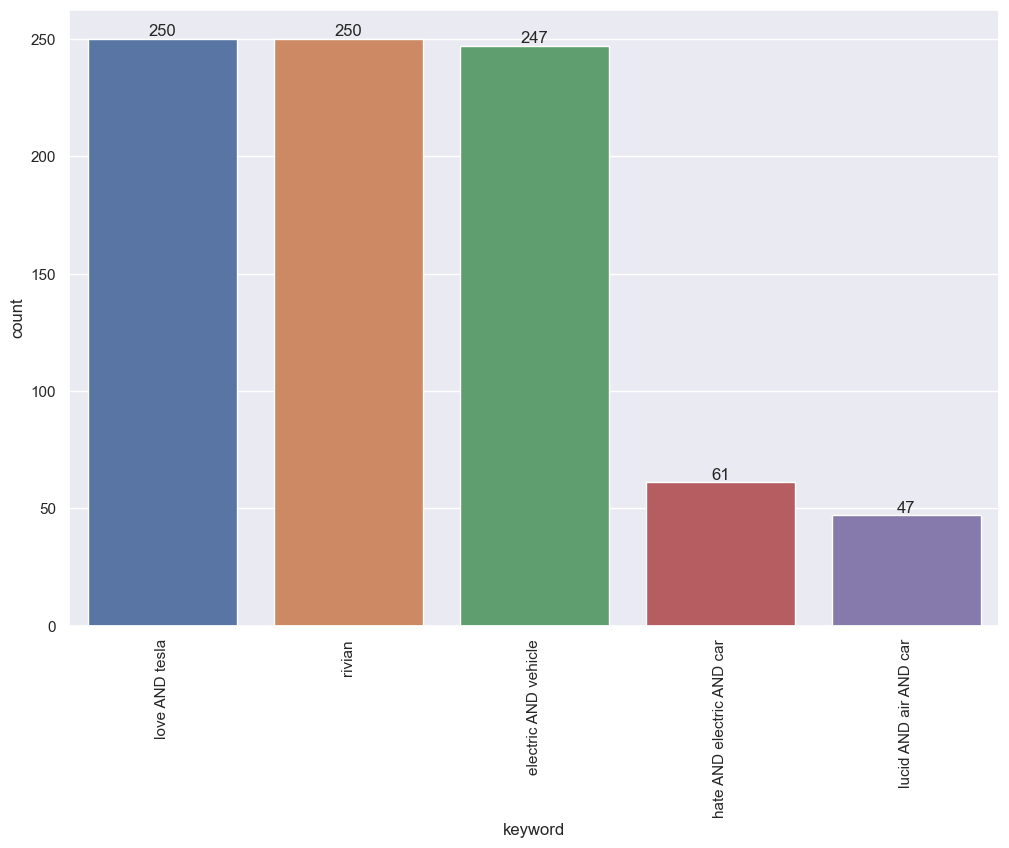

In [23]:
# distribution of keywords that we searched for

# potentially we need to write something about this

tmp = tweets.groupby('keyword').size().reset_index()
tmp.rename(columns={0:'count'}, inplace=True)
tmp.sort_values(by='count', ascending=False, inplace=True)

ax = sns.barplot(x='keyword', y='count', data=tmp)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

## Sentiment Analysis

In [29]:
tweets['sentiment_from_raw_tweets'] = tweets['text'].apply(lambda x: _get_sentiment(x))

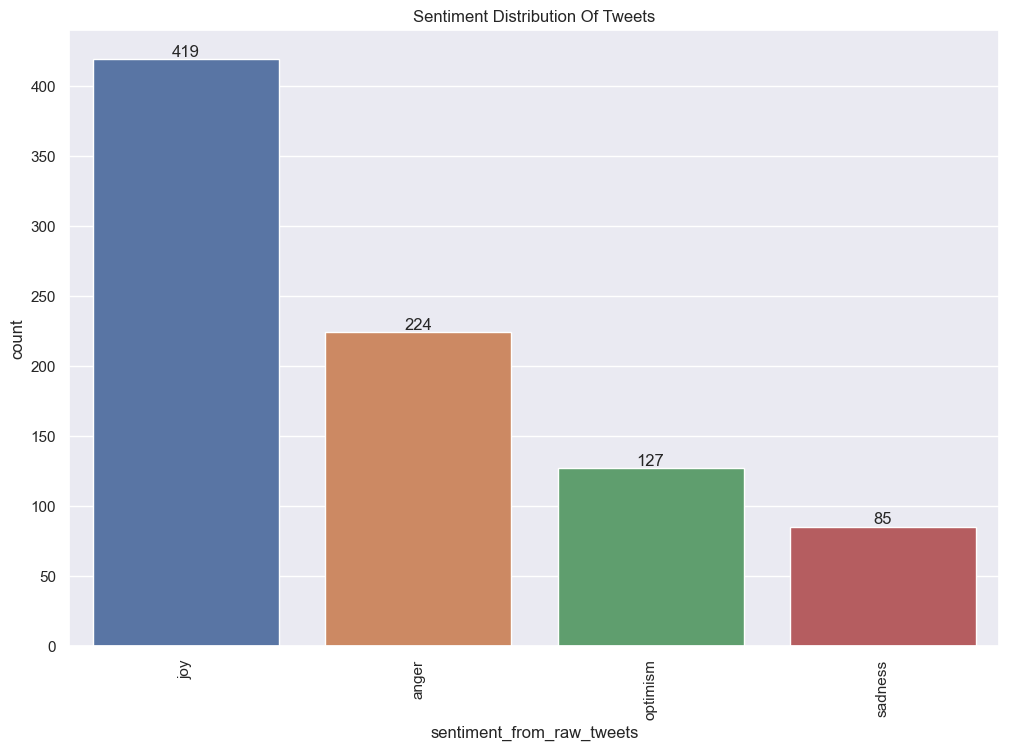

In [141]:
tmp = tweets.groupby('sentiment_from_raw_tweets').size().reset_index()
tmp.rename(columns={0:'count'}, inplace=True)
tmp.sort_values(by='count', ascending=False, inplace=True)

ax = sns.barplot(x='sentiment_from_raw_tweets', y='count', data=tmp)
ax.bar_label(ax.containers[0])
plt.title('Sentiment Distribution Of Tweets')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# showing examples of classified tweets

In [114]:
tweets[tweets['sentiment_from_raw_tweets'] == 'joy']['text'].sample(1).values[0]

"@JPUConn I LOVE my chrome Tesla plate frame. It doesn't have to match the trim"

In [136]:
tweets[tweets['sentiment_from_raw_tweets'] == 'anger']['text'].sample(1).values[0]

"@bgrahamdisciple Because it's still a trash electric vehicle with limited functionality"

In [153]:
# merge joy and optimism into one category and anger and sadness into another

tweets['simplified_sentiment'] = tweets['sentiment_from_raw_tweets'].apply(lambda x: _simplify_sentiment(x))

In [154]:
tweets['simplified_sentiment'].value_counts()

joy & optimism     546
anger & sadness    309
Name: simplified_sentiment, dtype: int64

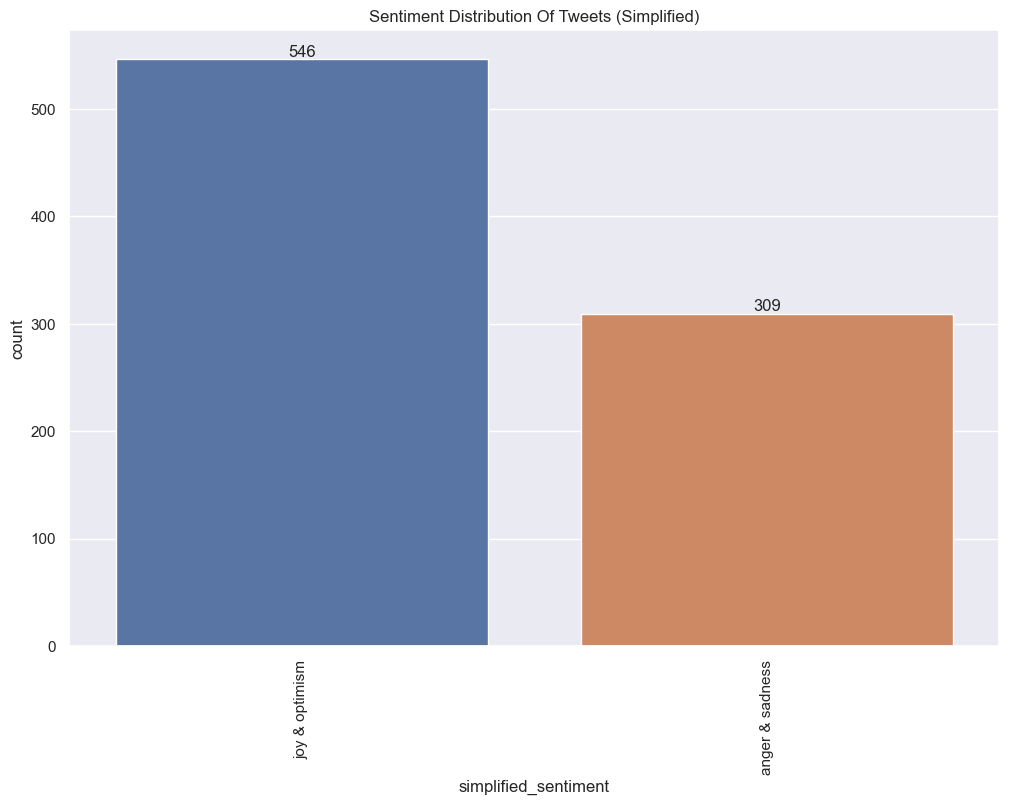

In [155]:
# conclusion / write up for this section

tmp = tweets.groupby('simplified_sentiment').size().reset_index()
tmp.rename(columns={0:'count'}, inplace=True)
tmp.sort_values(by='count', ascending=False, inplace=True)

ax = sns.barplot(x='simplified_sentiment', y='count', data=tmp)
ax.bar_label(ax.containers[0])
plt.title('Sentiment Distribution Of Tweets (Simplified)')
plt.xticks(rotation=90)
plt.show()

We can see that a lot of people from our sample feel positive emotions (joy & optimism) about electric vehicles. Roughly 35% of people feel anger and sadness when it comes to electric vehicles. This distribution does make sense because electric vehicles do bring a lot of new exciting innovations to the automative industry (hence ~67% of people are feeling positive about EVs) and there are also reservations about (plenty of reasons for that: cost, nostalgia factor etc.)

The sentiment analysis model was off the shelf huggingface model trained on twitter twitter sentiment analysis dataset. 

Here's the model reference: https://huggingface.co/cardiffnlp/twitter-roberta-base-dec2021-emotion?text=I+really+don%27t+like+electric+vehicles

Here's the dataset (model was trained on the emotion subset): https://huggingface.co/datasets/tweet_eval

Model as is performes well (84.5% F1 score on the mentioned dataset), but if we wanted to improve performance we would need to obtain a large sample of electric vehicle specific tweets and fine tune the language model.

## Topic Analysis

In [158]:
from nltk.stem import PorterStemmer

# stem the words for easier topic analysis
stemmer = PorterStemmer()
tweets['tweet_formatted'] = tweets['tweet_formatted'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [159]:
tweets.tweet_formatted.head()

0    new post i love how tesla wreak havoc among au...
1    garyblack00 elonmusk that fair question i love...
2    your definit sunday read veri balanc amp well ...
3           evasteslasplaid tesla classi sporti i love
4    elonmusk marionawf love elon wait tesla phone ...
Name: tweet_formatted, dtype: object

In [160]:
# extracting 3 main topics for joy and optimism tweets via LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

jo = tweets[tweets['simplified_sentiment'] == 'joy & optimism'].copy()

vectorizer = CountVectorizer(max_df=0.8, min_df=4, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(jo['tweet_formatted'].values.astype('U'))

lda_m = LatentDirichletAllocation(n_components=3, random_state=42)
lda_m.fit(doc_term_matrix)

# print top 10 words for each topic
for i,topic in enumerate(lda_m.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['like', 'spacex', 'mile', 'watch', 'elon', 'ev', 'great', 'elonmusk', 'love', 'tesla']


Top 10 words for topic #1:
['electr', 'model', 'im', 'time', 'air', 'elonmusk', 'lucid', 'car', 'love', 'tesla']


Top 10 words for topic #2:
['charg', 'look', 'r1', 'car', 'new', 'batteri', 'ev', 'vehicl', 'electr', 'rivian']




In [161]:
ast = tweets[tweets['simplified_sentiment'] == 'anger & sadness'].copy()

vectorizer = CountVectorizer(max_df=0.8, min_df=4, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(ast['tweet_formatted'].values.astype('U'))

lda_m = LatentDirichletAllocation(n_components=3, random_state=42)
lda_m.fit(doc_term_matrix)

# print top 10 words for each topic
for i,topic in enumerate(lda_m.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['dont', 'tesla', 'peopl', 'ev', 'charg', 'want', 'hate', 'vehicl', 'car', 'electr']


Top 10 words for topic #1:
['sell', 'brandenflasch', 'rantrack', 'look', 'time', 'like', 'elonmusk', 'love', 'tesla', 'rivian']


Top 10 words for topic #2:
['look', 'car', 'biden', 'lucid', 'chines', 'make', 'compani', 'need', 'vehicl', 'electr']




In the group of tweets where people had positive feelings towards EVs (joy and optimism) people were talking about how they love their teslas (first topic), about lucid air and electric cars (second topic) and about charging, batteries and rivian (third topic).

In a group of tweets where people were feeling negative about EVs (anger and sadness) they talked about how they don't like teslas (first topic), teslas competitors (second topic) and talked about politics and electric vehicles (third topic).

## Named Entity Recognition

In [186]:
from nltk import word_tokenize, pos_tag, ne_chunk

entityp = [] # people
entityo = [] # organization
entityg = [] # geo-political entity
entitydesc = [] # noun

def _get_ner_tags(x, entityp, entityo, entityg, entitydesc):
    pos_text = pos_tag(word_tokenize(x))
    ner_text = ne_chunk(pos_text)

    for x in str(ner_text).split('\n'):
        if 'PERSON' in x:
            entityp.append(x)
        elif 'ORGANIZATION' in x:
            entityo.append(x)
        elif 'GPE' in x or 'GSP' in x:
            entityg.append(x)
        elif '/NN' in x:
            entitydesc.append(x)

jo['text'].apply(lambda x: _get_ner_tags(x, entityp, entityo, entityg, entitydesc))

0      None
2      None
3      None
4      None
5      None
       ... 
823    None
825    None
834    None
842    None
856    None
Name: text, Length: 546, dtype: object

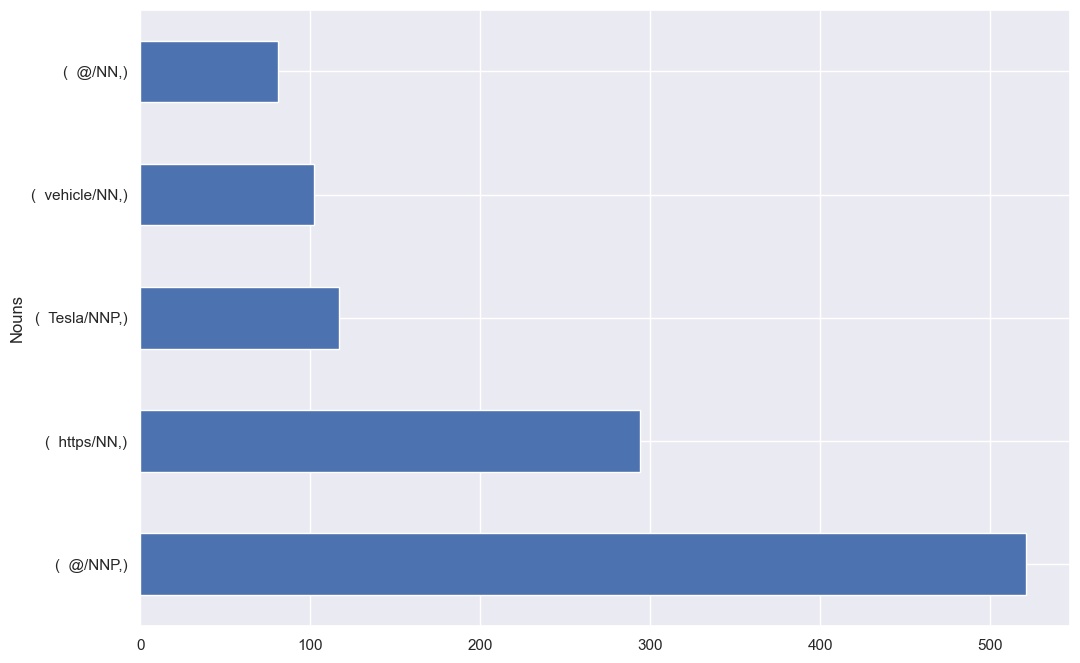

In [188]:
# top 5 nouns jo
noun_df = pd.DataFrame(entitydesc)
fig, ax = plt.subplots()
noun_df.value_counts().head(5).plot(kind='barh', xlabel='Nouns', ylabel='Frequency')
plt.show()

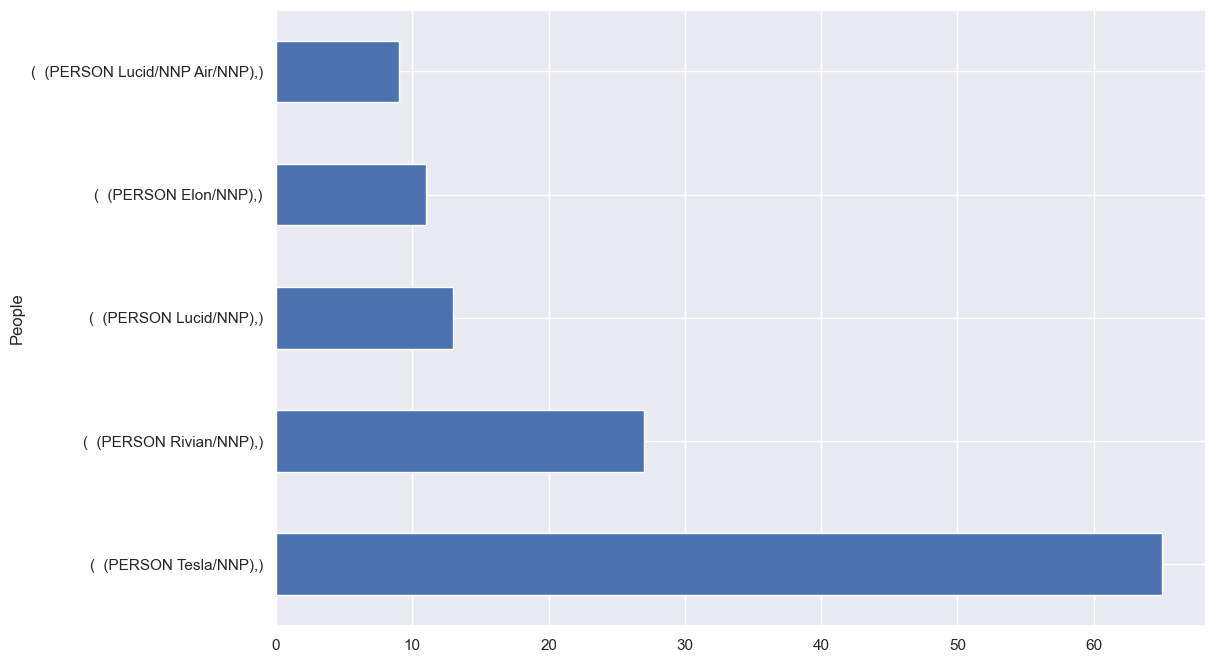

In [190]:
# top 5 people jo
people_df = pd.DataFrame(entityp)
fig, ax = plt.subplots()
people_df.value_counts().head(5).plot(ax=ax, kind='barh', xlabel='People', ylabel='Frequency')
plt.show()

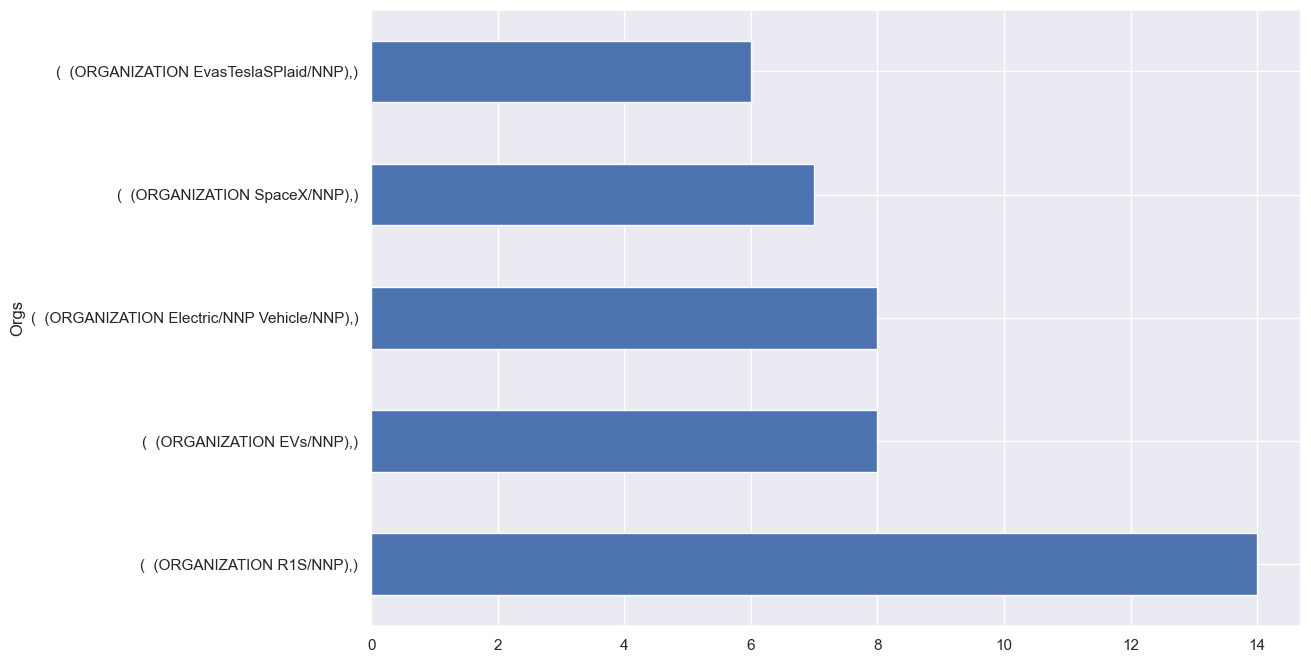

In [191]:
# top 5 organizations jo
org_df = pd.DataFrame(entityo)
fig, ax = plt.subplots()
org_df.value_counts().head(5).plot(ax=ax, kind='barh', xlabel='Orgs', ylabel='Frequency')
plt.show()

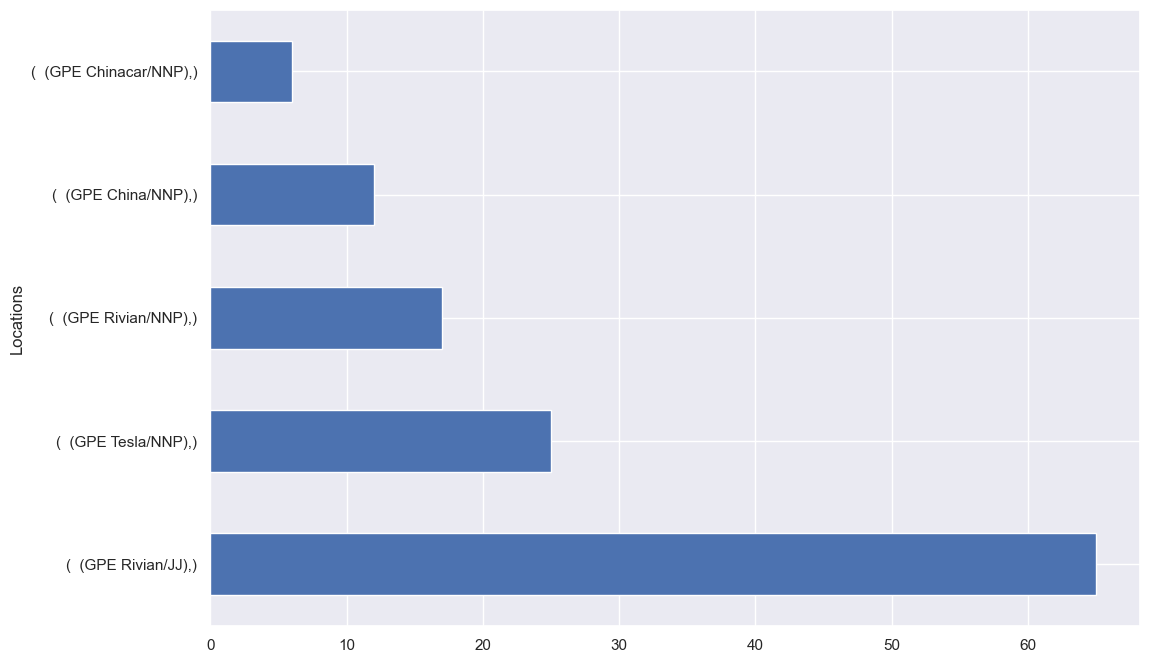

In [192]:
# top 5 locations
loc_df = pd.DataFrame(entityg)
fig, ax = plt.subplots()
loc_df.value_counts().head(5).plot(ax=ax, kind='barh', xlabel='Locations', ylabel='Frequency')
plt.show()

While our NER processes does need a lot of refinment (a lot of items that were in one top 5 charts are not captured correctly by the NER algorithm) we the results from above for tweets that were positive make sense. 

For our locattions, China is in top 5 and that make sense. Tesla is huge in that region and EVs in general. In the organizations top 5 SpaceX and Tesla pop out, which makes sense because Elon is the CEO of both of those companies and Tesla is a dominant player in the EV space. For people Elon stands out in top 5 again and that makes sense for the reasons we just mentioned. And for top 5 nouns vehicle & tesla stand out and those make sense because these tweets are about electric vehicles.

In [181]:
entityp1 = []
entityo1 = []
entityg1 = []
entitydesc1 = []

def _get_ner_tags(x, entityp, entityo, entityg, entitydesc):
    pos_text = pos_tag(word_tokenize(x))
    ner_text = ne_chunk(pos_text)

    for x in str(ner_text).split('\n'):
        if 'PERSON' in x:
            entityp1.append(x)
        elif 'ORGANIZATION' in x:
            entityo1.append(x)
        elif 'GPE' in x or 'GSP' in x:
            entityg1.append(x)
        elif '/NN' in x:
            entitydesc1.append(x)

ast['text'].apply(lambda x: _get_ner_tags(x, entityp1, entityo1, entityg1, entitydesc1))

1      None
32     None
35     None
39     None
40     None
       ... 
852    None
853    None
854    None
855    None
857    None
Name: text, Length: 309, dtype: object

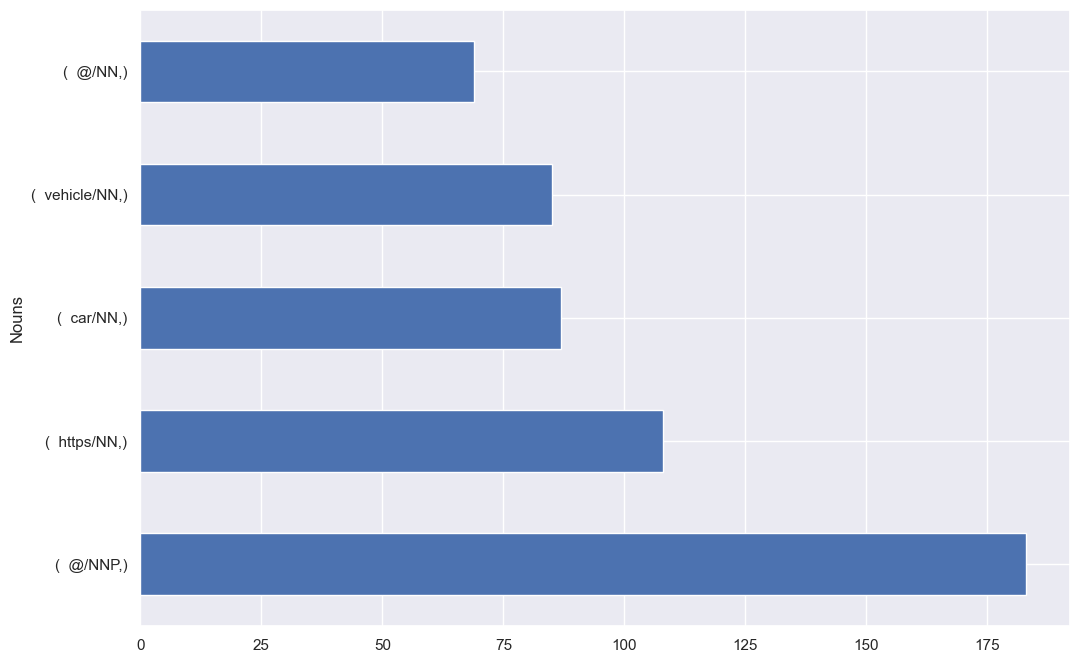

In [193]:
# top 5 nouns ast
noun_df = pd.DataFrame(entitydesc1)
fig, ax = plt.subplots()
noun_df.value_counts().head(5).plot(kind='barh', xlabel='Nouns', ylabel='Frequency')
plt.show()

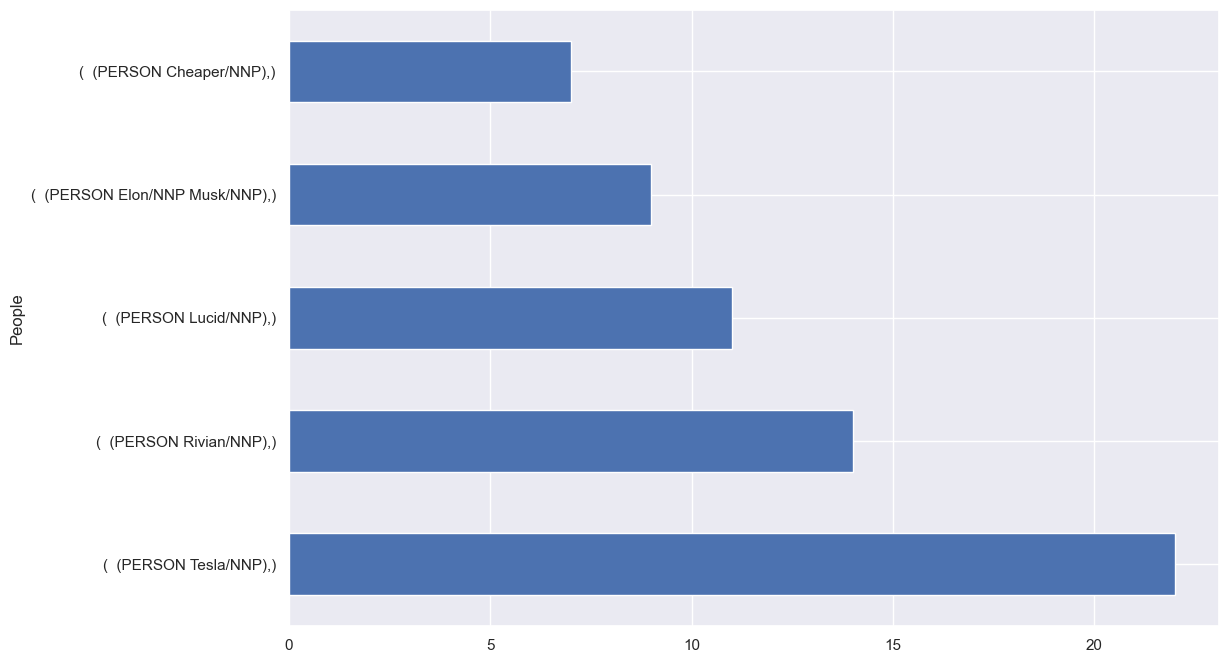

In [194]:
# top 5 people ast
people_df = pd.DataFrame(entityp1)
fig, ax = plt.subplots()
people_df.value_counts().head(5).plot(ax=ax, kind='barh', xlabel='People', ylabel='Frequency')
plt.show()

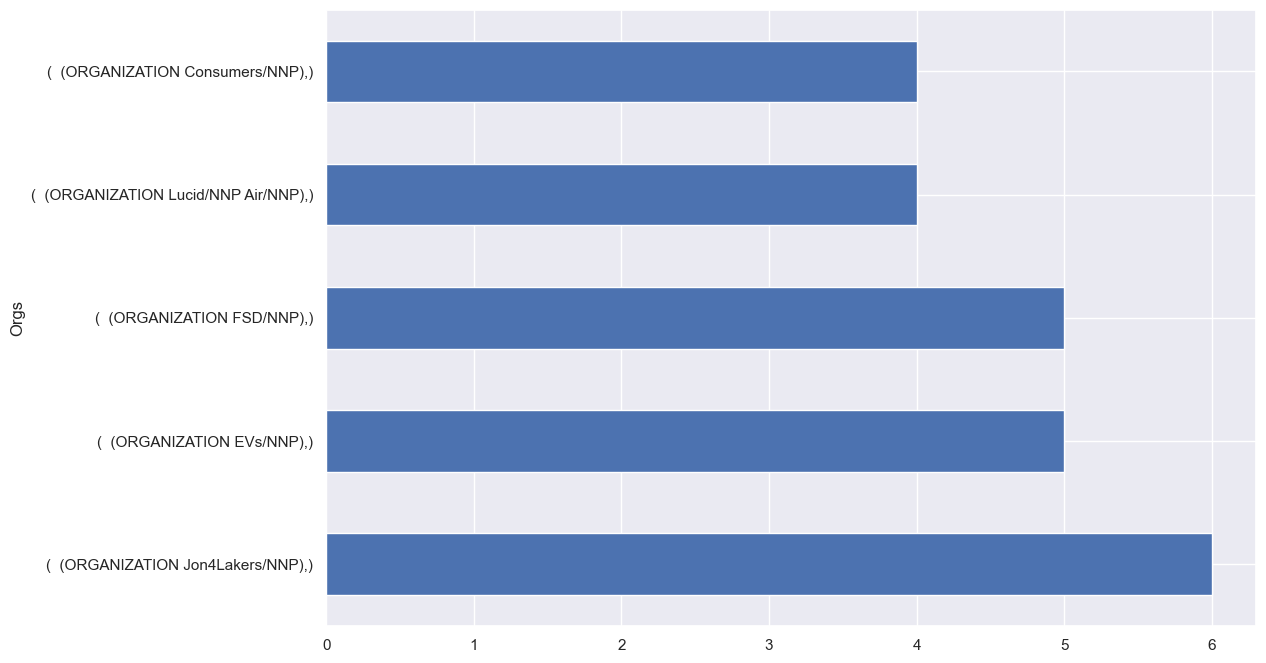

In [195]:
# top 5 organizations ast
org_df = pd.DataFrame(entityo1)
fig, ax = plt.subplots()
org_df.value_counts().head(5).plot(ax=ax, kind='barh', xlabel='Orgs', ylabel='Frequency')
plt.show()

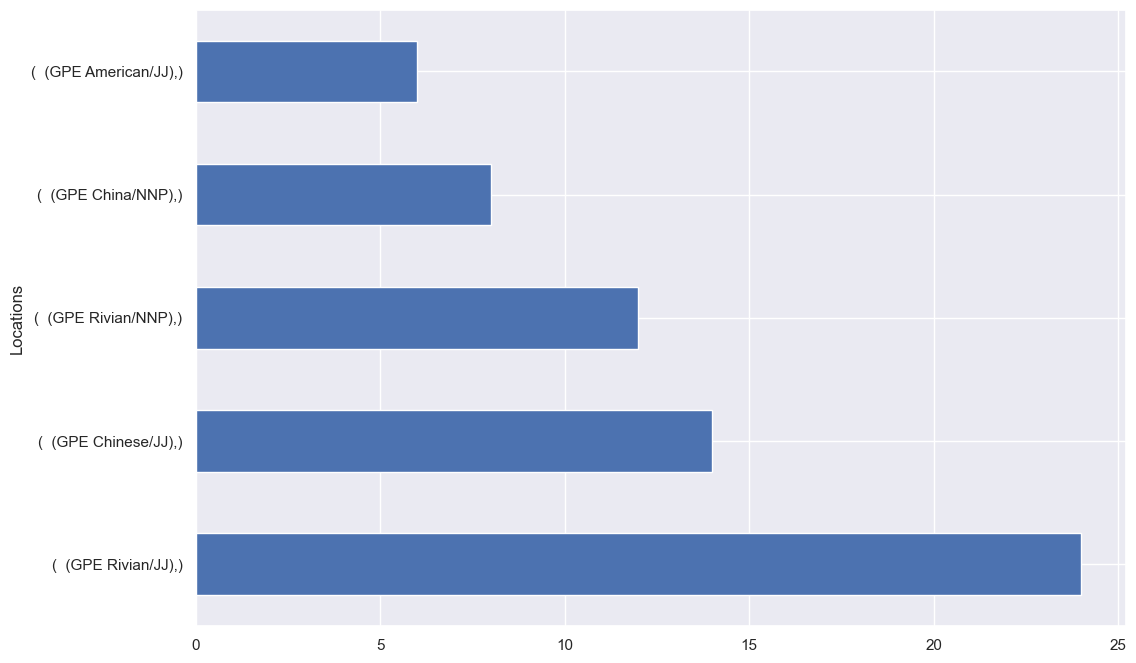

In [196]:
# top 5 locations
loc_df = pd.DataFrame(entityg1)
fig, ax = plt.subplots()
loc_df.value_counts().head(5).plot(ax=ax, kind='barh', xlabel='Locations', ylabel='Frequency')
plt.show()

While again our NER process does need refinment results we see above from negative tweets make sense.

Vehicle and Car stand out in top 5 nouns, Elon in people, Lucid in organizations and China and America in locations. These are in line with electric vehicle discussions in general for the similar reasons we mentioned in the NER analysis above (for positive tweets).

In the topic analysis that we did people were talking about their love (or hate) for the Tesla, their competitors, China and Elon and those topics align with the NER analysis that we did.